In [13]:
import os
from pathlib import Path

import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import librosa
import joblib
import matplotlib.pyplot as plt

# ---------------- CONFIG ----------------
MODEL_PATH = Path("output/shapelet_model.joblib")  # adjust
DATA_DIR = Path("../../data/bee_sounds")                   # adjust to your root

# --------- LOAD MODEL + CONFIG ----------
obj = joblib.load(MODEL_PATH)
shapelets = obj["shapelets"]            # (K, L)
shapelet_length = obj["shapelet_length"]
target_len = obj["target_len"]
sr = obj["sr"]
frame_length = obj["frame_length"]
hop_length = obj["hop_length"]
CLASS_DIRS = obj["class_dirs"]          # {0: "...", 1: "..."}

K, L = shapelets.shape
print(f"Loaded {K} shapelets of length {L}")

# --------- DATA PREP (same as training) ----------
def extract_energy_series(path, sr=16000, frame_length=1024, hop_length=512):
    y, sr = librosa.load(path, sr=sr, mono=True)
    if y.size == 0:
        return np.zeros(1, dtype=np.float32)
    rms = librosa.feature.rms(
        y=y,
        frame_length=frame_length,
        hop_length=hop_length,
        center=True,
    )[0]
    return rms.astype(np.float32)

def load_bee_dataset(root_dir, class_dirs, target_len, sr, frame_length, hop_length):
    X_list, y_list, paths = [], [], []
    for label, sub_name in class_dirs.items():
        folder = root_dir / sub_name
        if not folder.is_dir():
            raise FileNotFoundError(f"Folder not found: {folder}")
        for fname in os.listdir(folder):
            if not fname.lower().endswith((".wav", ".flac", ".mp3", ".ogg")):
                continue
            path = folder / fname
            ts = extract_energy_series(
                path,
                sr=sr,
                frame_length=frame_length,
                hop_length=hop_length,
            )
            if ts.shape[0] < target_len:
                continue
            X_list.append(ts[:target_len].astype(np.float32))
            y_list.append(label)
            paths.append(str(path))
    X = np.stack(X_list, axis=0)
    y = np.array(y_list, dtype=np.int64)
    return X, y, paths

X, y, paths = load_bee_dataset(
    DATA_DIR,
    CLASS_DIRS,
    target_len=target_len,
    sr=sr,
    frame_length=frame_length,
    hop_length=hop_length,
)
print(f"X shape: {X.shape}, y shape: {y.shape}")

# --------- DISTANCES + BEST POSITIONS ----------
def compute_shapelet_distances_and_positions(X, shapelets):
    N, T = X.shape
    K, L = shapelets.shape
    windows = sliding_window_view(X, window_shape=L, axis=1)  # (N, num_windows, L)

    W = windows[:, np.newaxis, :, :]           # (N, 1, num_windows, L)
    S = shapelets[np.newaxis, :, np.newaxis, :]# (1, K, 1, L)

    diff = W - S
    dists = np.sqrt(np.sum(diff * diff, axis=-1))  # (N, K, num_windows)

    min_dists = dists.min(axis=2)        # (N, K)
    best_pos = dists.argmin(axis=2)      # (N, K)
    return min_dists, best_pos

min_dists, best_pos = compute_shapelet_distances_and_positions(X, shapelets)
print("Distances and best positions computed.")


Loaded 10 shapelets of length 40
X shape: (6000, 51), y shape: (6000,)
Distances and best positions computed.


Shapelets assigned to classes (effect >= 0.3):
  class 0 (QueenBee Absent): [0, 1, 2, 3, 4]
  class 1 (QueenBee Present): [5, 6, 7, 8]

Class 0 (QueenBee Absent): plotting shapelets [0, 1, 2, 3, 4]
  plotting shapelet 0 (effect=0.817)


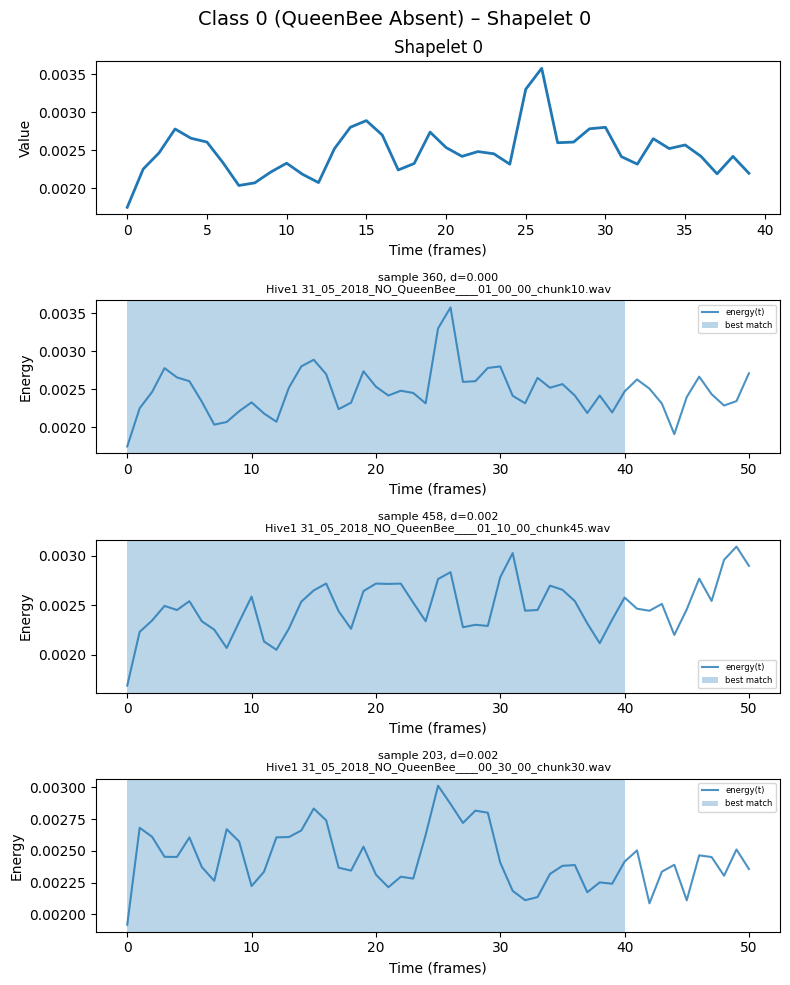

  plotting shapelet 1 (effect=0.817)


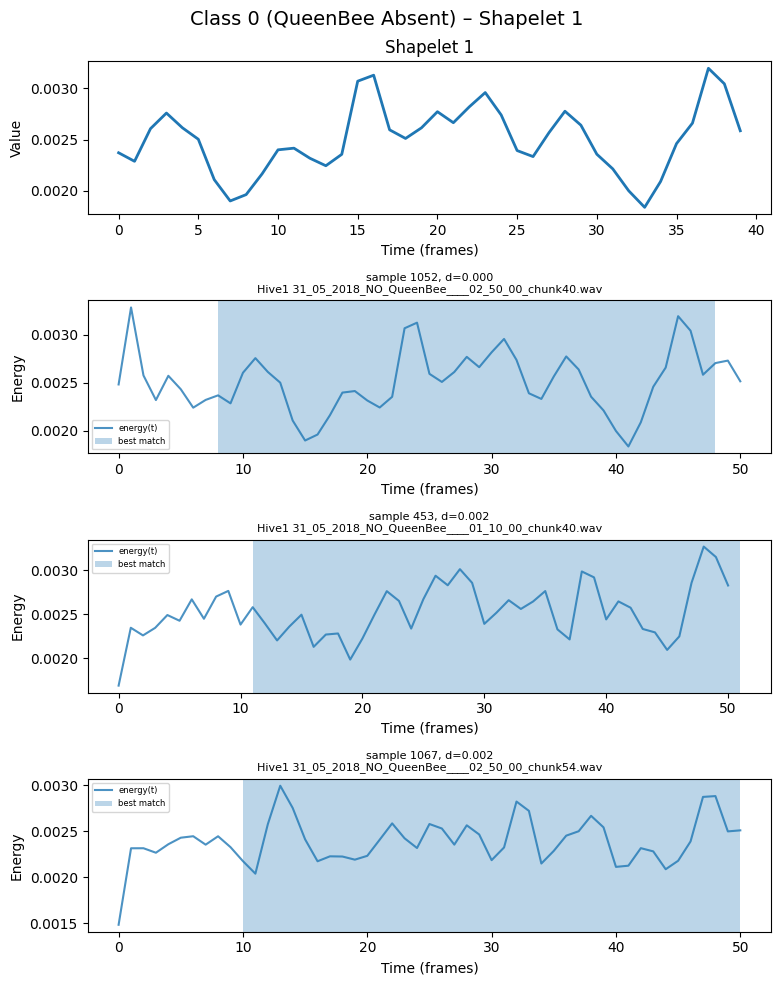

  plotting shapelet 2 (effect=0.808)


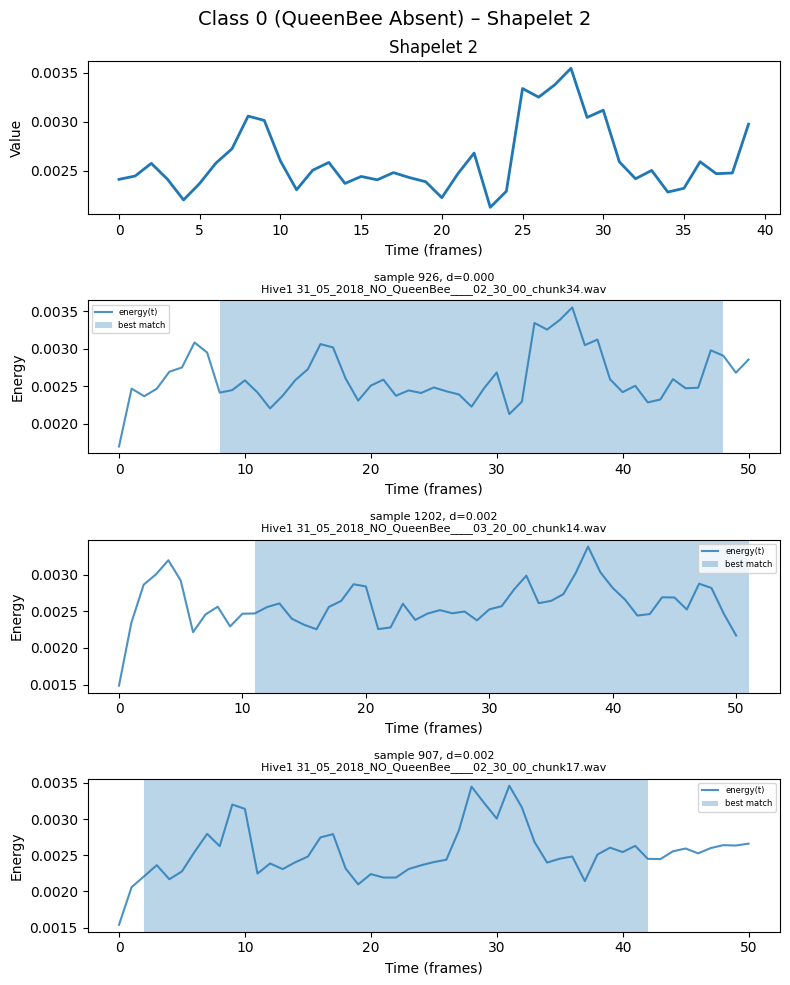

  plotting shapelet 3 (effect=0.804)


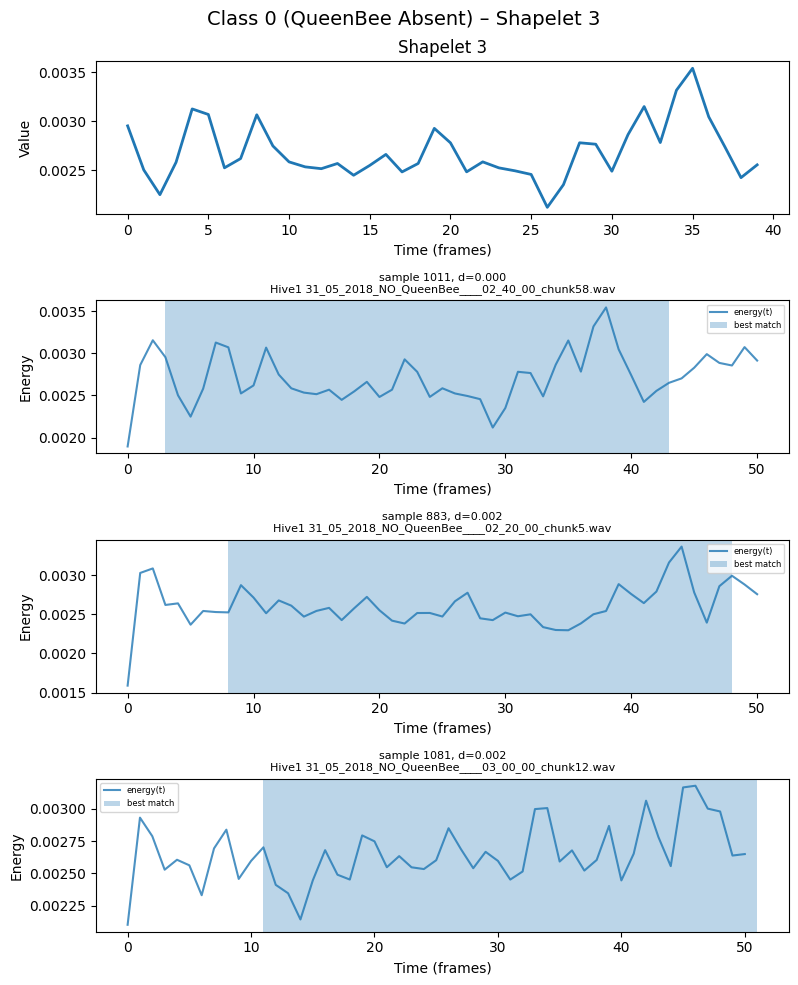

  plotting shapelet 4 (effect=0.802)


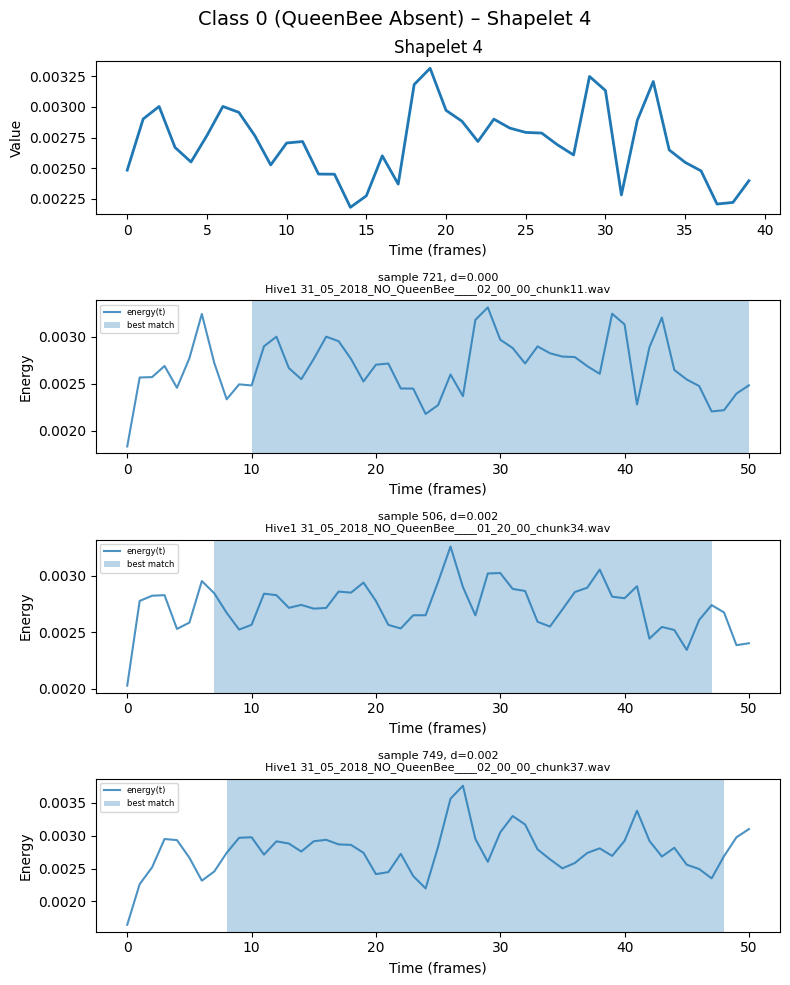


Class 1 (QueenBee Present): plotting shapelets [5, 6, 7, 8]
  plotting shapelet 5 (effect=1.048)


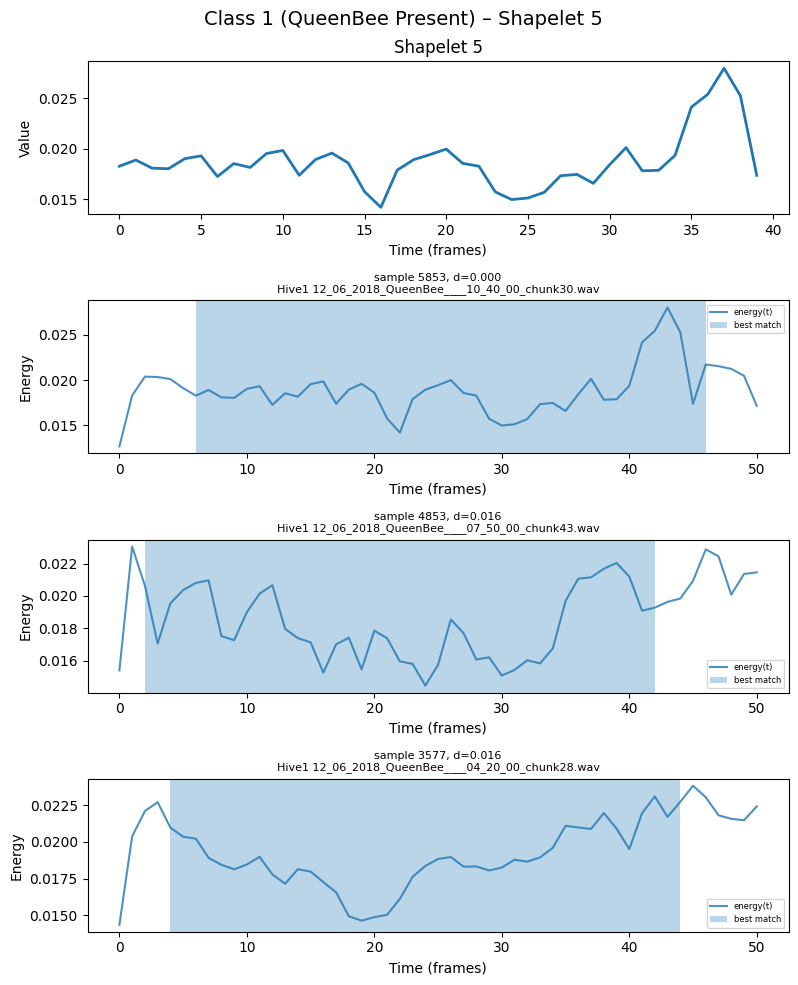

  plotting shapelet 6 (effect=0.939)


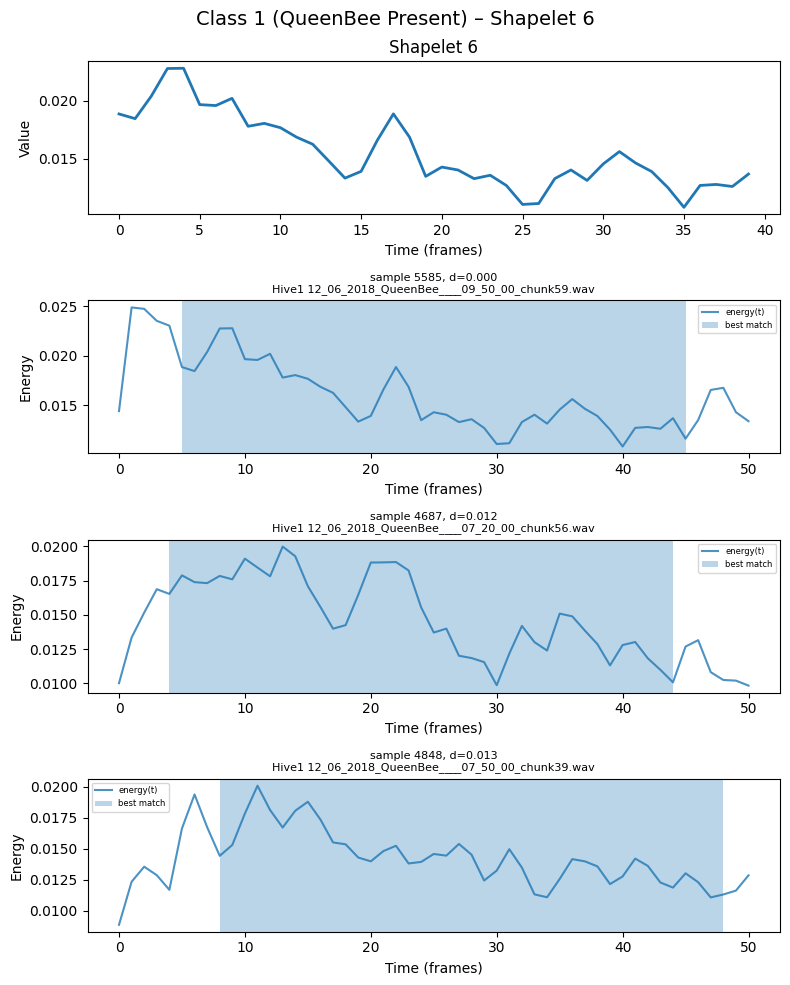

  plotting shapelet 7 (effect=0.578)


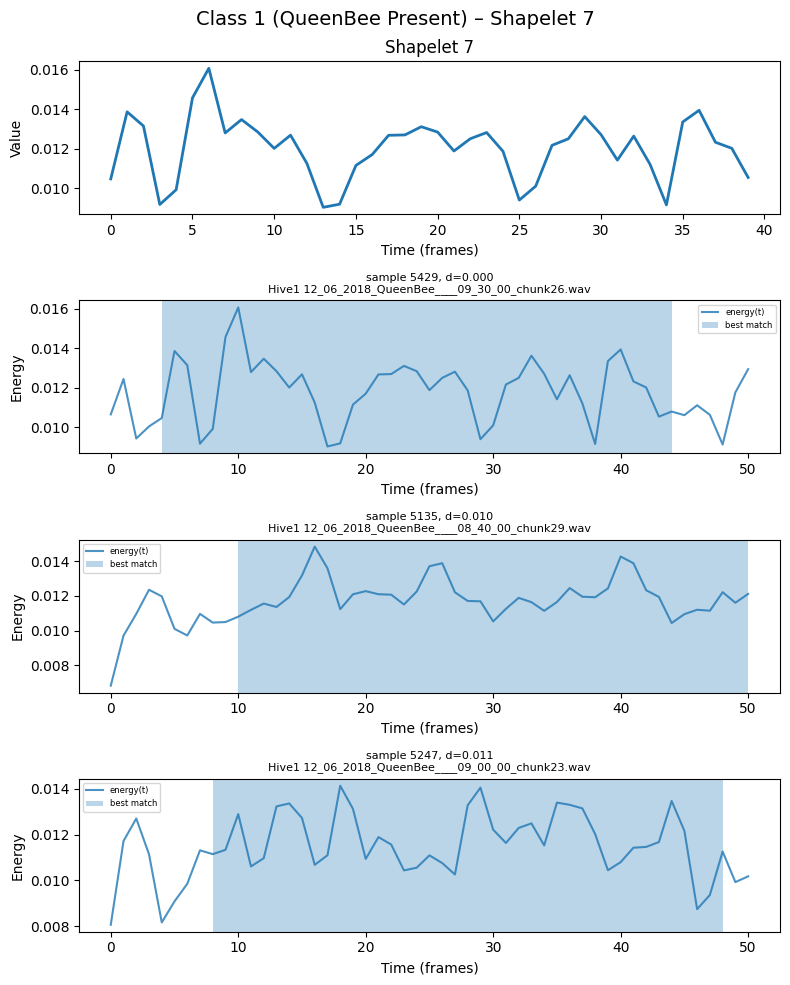

  plotting shapelet 8 (effect=0.406)


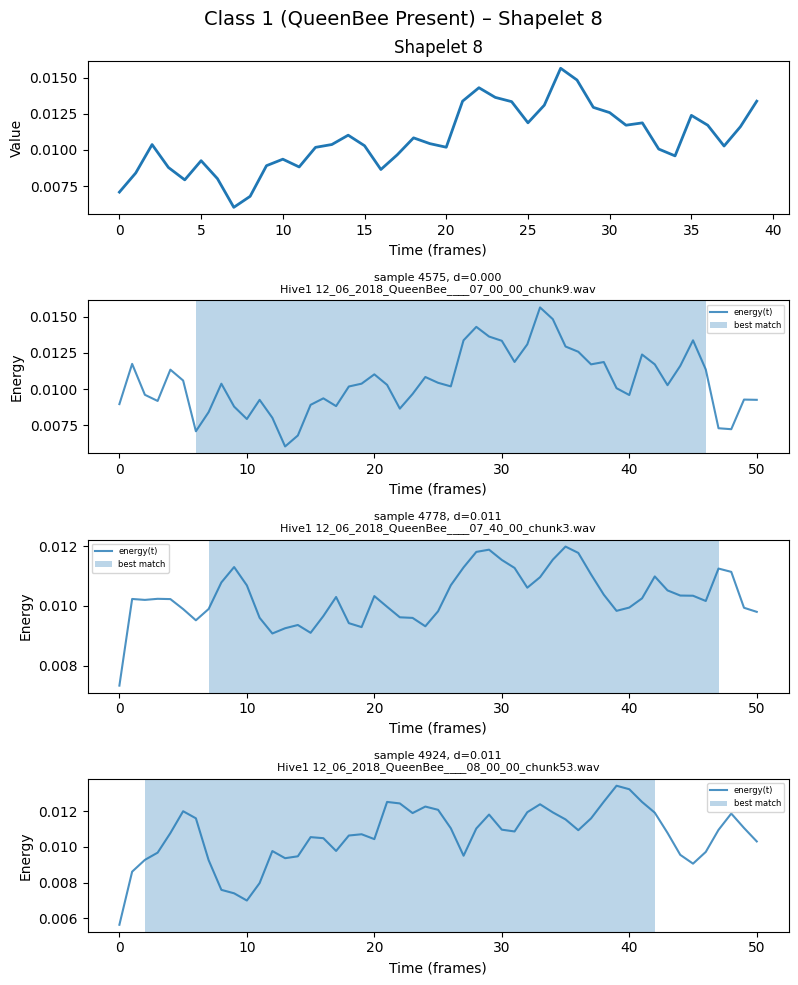

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import os

# ---------- 1. EFFECT SIZES: WHICH CLASS OWNS WHICH SHAPELET ----------

classes = np.unique(y)          # e.g. [0, 1]
K = shapelets.shape[0]          # number of shapelets

def compute_effects_per_class(min_dists, y):
    """
    min_dists: (N, K)  distances to each shapelet
    y: (N,)   labels
    returns:
        effects: (K, C) where C = n_classes
        class_ids: array of class labels in the same order
    effects[k, c] > 0  => class c tends to have *smaller* distances to shapelet k
    """
    class_ids = np.unique(y)
    C = len(class_ids)
    effects = np.zeros((K, C), dtype=np.float32)

    for k in range(K):
        d_k = min_dists[:, k]
        for ci, cls in enumerate(class_ids):
            pos = d_k[y == cls]
            neg = d_k[y != cls]
            if len(pos) < 2 or len(neg) < 2:
                effects[k, ci] = 0.0
                continue
            mu_pos = pos.mean()
            mu_neg = neg.mean()
            var_pos = pos.var(ddof=1)
            var_neg = neg.var(ddof=1)
            n_pos = len(pos)
            n_neg = len(neg)
            pooled = ((n_pos - 1) * var_pos + (n_neg - 1) * var_neg) / (n_pos + n_neg - 2)
            pooled = np.sqrt(pooled + 1e-8)
            # positive if class cls has smaller distances (closer)
            effect = (mu_neg - mu_pos) / pooled
            effects[k, ci] = effect
    return effects, class_ids

effects, class_ids = compute_effects_per_class(min_dists, y)

def assign_shapelets_to_classes(effects, class_ids, min_effect=0.3):
    """
    Assign each shapelet to the class where it has maximum positive effect.
    Only keep assignments with effect >= min_effect.
    Returns dict: {class_label: [shapelet_idx, ...]}
    """
    K, C = effects.shape
    shapelets_by_class = {cls: [] for cls in class_ids}

    for k in range(K):
        ci_max = np.argmax(effects[k])
        best_eff = effects[k, ci_max]
        if best_eff >= min_effect:
            cls = class_ids[ci_max]
            shapelets_by_class[cls].append(k)
    return shapelets_by_class

shapelets_by_class = assign_shapelets_to_classes(effects, class_ids, min_effect=0.3)

print("Shapelets assigned to classes (effect >= 0.3):")
for cls in class_ids:
    label_name = CLASS_DIRS.get(cls, str(cls))
    print(f"  class {cls} ({label_name}): {shapelets_by_class[cls]}")


# ---------- 2. PLOTTING: ONE FIGURE PER (CLASS, SHAPELET) ----------

def plot_shapelet_for_class(cls, shapelet_idx, top_n=3):
    """
    For a given class and shapelet:
      - row 0: the shapelet
      - next rows: top-N series from that class,
        with best-match window highlighted.
    """
    sh = shapelets[shapelet_idx]        # (L,)
    L = sh.shape[0]
    cls_mask = (y == cls)
    if not np.any(cls_mask):
        print(f"No samples for class {cls}")
        return

    # distances and indices restricted to this class
    d_cls = min_dists[cls_mask, shapelet_idx]
    idx_cls = np.where(cls_mask)[0]

    # sort by distance ascending (closest first)
    order = np.argsort(d_cls)
    top = order[:top_n]

    # figure layout: 1 (shapelet) + top_n series
    n_rows = 1 + len(top)
    fig, axes = plt.subplots(
        n_rows,
        1,
        figsize=(8, 2.5 * n_rows),
        squeeze=False,
    )
    axes = axes[:, 0]  # flatten to 1D

    title_cls = CLASS_DIRS.get(cls, str(cls))
    fig.suptitle(f"Class {cls} ({title_cls}) – Shapelet {shapelet_idx}", fontsize=14)

    # row 0: shapelet
    t_sh = np.arange(L)
    ax0 = axes[0]
    ax0.plot(t_sh, sh, linewidth=2)
    ax0.set_title(f"Shapelet {shapelet_idx}")
    ax0.set_xlabel("Time (frames)")
    ax0.set_ylabel("Value")

    # rows 1..: best matches in this class
    for r, o in enumerate(top, start=1):
        series_idx = idx_cls[o]
        series = X[series_idx]           # (T,)
        pos = best_pos[series_idx, shapelet_idx]
        start = pos
        end = pos + L

        ax = axes[r]
        t = np.arange(series.shape[0])

        ax.plot(t, series, alpha=0.8, label="energy(t)")
        ax.axvspan(start, end, alpha=0.3, label="best match")

        fname = os.path.basename(paths[series_idx])
        ax.set_title(f"sample {series_idx}, d={d_cls[o]:.3f}\n{fname}", fontsize=8)
        ax.set_xlabel("Time (frames)")
        ax.set_ylabel("Energy")
        ax.legend(fontsize=6, loc="best")

    plt.tight_layout()
    plt.show()


# ---------- 3. SHOW ALL SHAPELETS PER CLASS ----------

for cls in class_ids:
    cls_name = CLASS_DIRS.get(cls, str(cls))
    sh_list = shapelets_by_class[cls]
    if not sh_list:
        print(f"\nClass {cls} ({cls_name}): no strongly class-biased shapelets.")
        continue

    print(f"\nClass {cls} ({cls_name}): plotting shapelets {sh_list}")
    for k in sh_list:
        print(f"  plotting shapelet {k} (effect={effects[k, np.where(class_ids==cls)[0][0]]:.3f})")
        plot_shapelet_for_class(cls, k, top_n=3)


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import os

def plot_shapelets_two_columns(top_n=3, min_effect=0.3):
    """
    2 columns:
      - left: shapelets biased to class 0 (orange)
      - right: shapelets biased to class 1 (blue)

    For each class+shapelet:
      - plot the shapelet
      - overlay top-N best-matching windows from that class (aligned to t=0)
    """
    # expect exactly 2 classes
    classes = sorted(np.unique(y))
    if len(classes) != 2:
        raise ValueError(f"Expected 2 classes, found {classes}")

    cls0, cls1 = classes
    name0 = CLASS_DIRS.get(cls0, str(cls0))
    name1 = CLASS_DIRS.get(cls1, str(cls1))

    # if you didn't run the assignment code yet, recompute quickly
    K = shapelets.shape[0]
    if "effects" not in globals() or "class_ids" not in globals():
        print("effects/class_ids not in globals – recomputing quickly.")
        from math import sqrt
        global effects, class_ids
        class_ids = np.unique(y)
        C = len(class_ids)
        effects = np.zeros((K, C), dtype=np.float32)
        for k in range(K):
            d_k = min_dists[:, k]
            for ci, cls in enumerate(class_ids):
                pos = d_k[y == cls]
                neg = d_k[y != cls]
                if len(pos) < 2 or len(neg) < 2:
                    effects[k, ci] = 0.0
                    continue
                mu_pos = pos.mean()
                mu_neg = neg.mean()
                var_pos = pos.var(ddof=1)
                var_neg = neg.var(ddof=1)
                n_pos = len(pos)
                n_neg = len(neg)
                pooled = ((n_pos - 1) * var_pos + (n_neg - 1) * var_neg) / (n_pos + n_neg - 2)
                pooled = np.sqrt(pooled + 1e-8)
                effects[k, ci] = (mu_neg - mu_pos) / pooled

    # assign shapelets to each class by max effect
    def assign(effects, class_ids, min_effect):
        K, C = effects.shape
        out = {cls: [] for cls in class_ids}
        for k in range(K):
            ci_max = np.argmax(effects[k])
            best_eff = effects[k, ci_max]
            if best_eff >= min_effect:
                out[class_ids[ci_max]].append(k)
        return out

    shapelets_by_class_local = assign(effects, class_ids, min_effect=min_effect)
    s0 = shapelets_by_class_local.get(cls0, [])
    s1 = shapelets_by_class_local.get(cls1, [])

    print(f"class {cls0} ({name0}) shapelets: {s0}")
    print(f"class {cls1} ({name1}) shapelets: {s1}")

    n_rows = max(len(s0), len(s1))
    if n_rows == 0:
        print("No shapelets pass the effect threshold.")
        return

    fig, axes = plt.subplots(
        n_rows,
        2,
        figsize=(10, 3 * n_rows),
        squeeze=False,
    )

    # helper to draw one cell
    def draw_cell(ax, cls, shapelet_idx, color):
        sh = shapelets[shapelet_idx]        # (L,)
        L = sh.shape[0]
        t_sh = np.arange(L)

        # plot shapelet
        ax.plot(t_sh, sh, color=color, linewidth=2, label=f"shapelet {shapelet_idx}")

        # best matches inside this class
        mask = (y == cls)
        d_cls = min_dists[mask, shapelet_idx]
        idx_cls = np.where(mask)[0]
        order = np.argsort(d_cls)
        top = order[:top_n]

        for o in top:
            series_idx = idx_cls[o]
            series = X[series_idx]
            pos = best_pos[series_idx, shapelet_idx]
            window = series[pos : pos + L]
            if window.shape[0] < L:
                continue
            ax.plot(t_sh, window, alpha=0.5, linewidth=1)

        cname = CLASS_DIRS.get(cls, str(cls))
        eff = effects[shapelet_idx, np.where(class_ids == cls)[0][0]]
        ax.set_title(f"{cname} – sh {shapelet_idx} (eff={eff:.2f})")
        ax.set_xlabel("Time (frames)")
        ax.set_ylabel("Energy / value")

    # fill grid
    for row in range(n_rows):
        # left column: class 0, orange
        if row < len(s0):
            k0 = s0[row]
            draw_cell(axes[row, 0], cls0, k0, color="orange")
        else:
            axes[row, 0].axis("off")

        # right column: class 1, blue
        if row < len(s1):
            k1 = s1[row]
            draw_cell(axes[row, 1], cls1, k1, color="blue")
        else:
            axes[row, 1].axis("off")

    plt.tight_layout()
    plt.show()


Left column: orange plots = shapelets (with best-matching windows) characteristic for class 0.


Right column: blue plots = shapelets (with best-matching windows) characteristic for class 1.

class 0 (QueenBee Absent) shapelets: [0, 1, 2, 3, 4]
class 1 (QueenBee Present) shapelets: [5, 6, 7, 8]


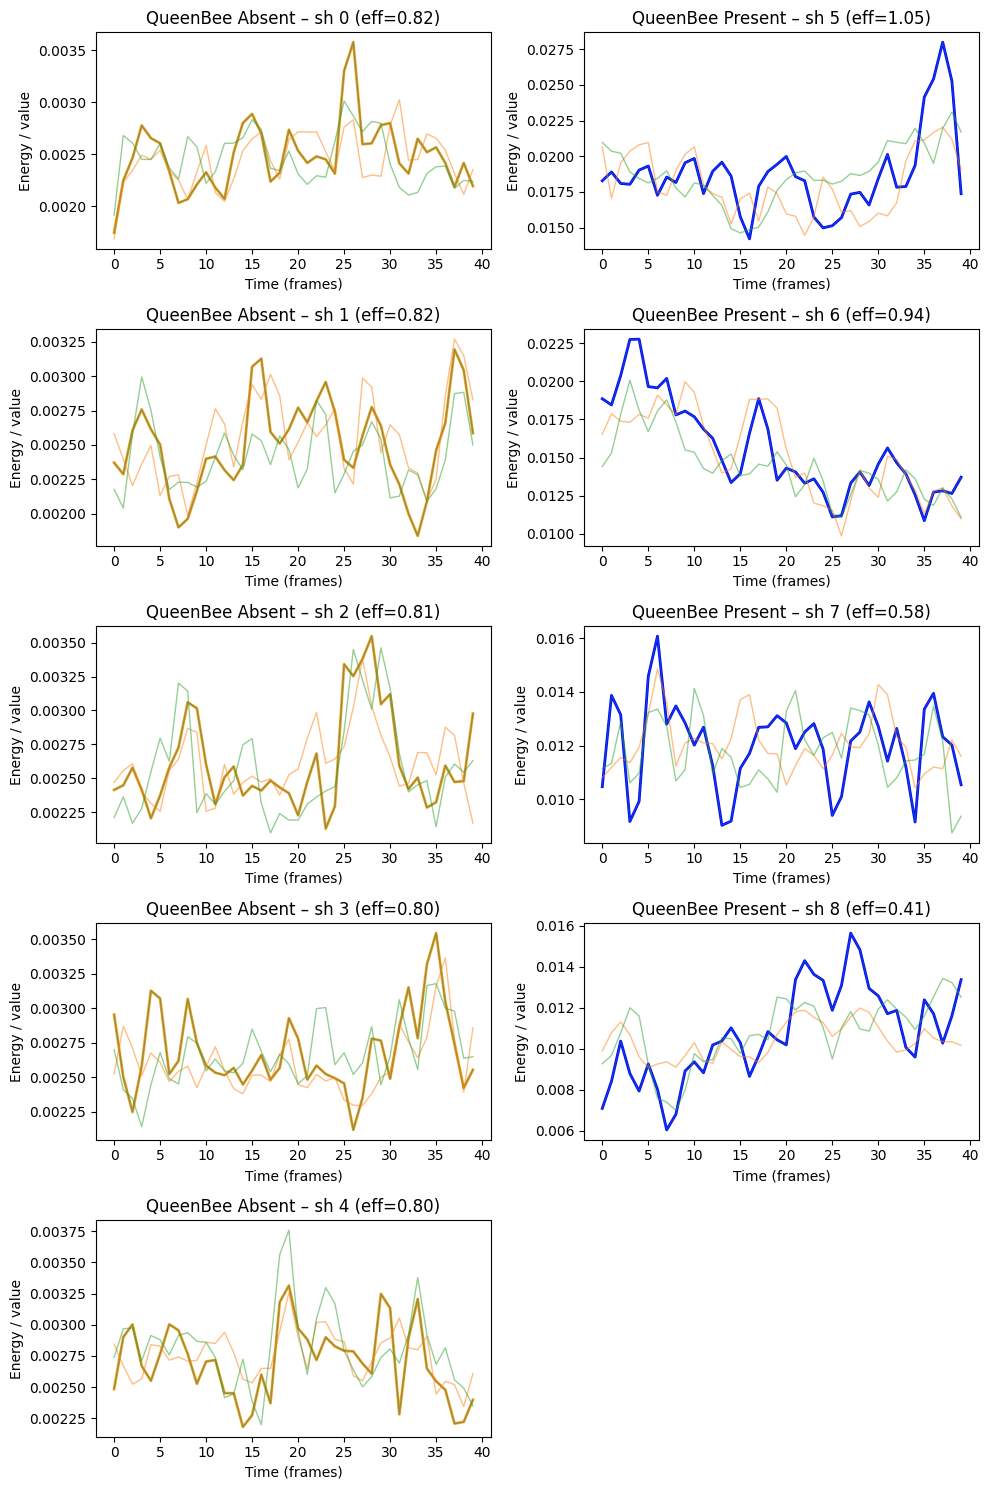

In [20]:
plot_shapelets_two_columns(top_n=3, min_effect=0.3)


In [27]:
from sklearn.metrics import classification_report

clf = obj["classifier"]
scaler = obj["scaler"]

# features for classifier are exactly the min distances
X_feat_all = min_dists.astype(np.float32)
X_scaled_all = scaler.transform(X_feat_all)

y_pred_all = clf.predict(X_scaled_all)

print(classification_report(y, y_pred_all))


              precision    recall  f1-score   support

           0       0.83      0.81      0.82      2000
           1       0.91      0.92      0.91      4000

    accuracy                           0.88      6000
   macro avg       0.87      0.86      0.87      6000
weighted avg       0.88      0.88      0.88      6000



In [28]:
import numpy as np
import matplotlib.pyplot as plt

def plot_shapelets_two_columns_correct(top_n=3, min_effect=0.3):
    """
    2 columns:
      - left: shapelets biased to class 0 (orange)
      - right: shapelets biased to class 1 (blue)

    For each class+shapelet:
      - plot the shapelet
      - overlay top-N best-matching windows from that class
        among samples that are CORRECTLY classified (y_pred_all == y).
    """

    # classes (assume binary: 0 and 1)
    classes = sorted(np.unique(y))
    if len(classes) != 2:
        raise ValueError(f"Expected 2 classes, found {classes}")

    cls0, cls1 = classes
    name0 = CLASS_DIRS.get(cls0, str(cls0))
    name1 = CLASS_DIRS.get(cls1, str(cls1))

    K = shapelets.shape[0]

    # ---- compute effects per class (local, no globals) ----
    class_ids = np.unique(y)
    C = len(class_ids)
    effects = np.zeros((K, C), dtype=np.float32)

    for k in range(K):
        d_k = min_dists[:, k]
        for ci, cls in enumerate(class_ids):
            pos = d_k[y == cls]
            neg = d_k[y != cls]
            if len(pos) < 2 or len(neg) < 2:
                effects[k, ci] = 0.0
                continue
            mu_pos = pos.mean()
            mu_neg = neg.mean()
            var_pos = pos.var(ddof=1)
            var_neg = neg.var(ddof=1)
            n_pos = len(pos)
            n_neg = len(neg)
            pooled = ((n_pos - 1) * var_pos + (n_neg - 1) * var_neg) / (n_pos + n_neg - 2)
            pooled = np.sqrt(pooled + 1e-8)
            # positive if class cls has smaller distances (closer)
            effects[k, ci] = (mu_neg - mu_pos) / pooled

    # ---- assign shapelets to classes by max effect ----
    def assign_shapelets(effects, class_ids, min_effect):
        K, C = effects.shape
        out = {cls: [] for cls in class_ids}
        for k in range(K):
            ci_max = np.argmax(effects[k])
            best_eff = effects[k, ci_max]
            if best_eff >= min_effect:
                out[class_ids[ci_max]].append(k)
        return out

    shapelets_by_class_local = assign_shapelets(effects, class_ids, min_effect=min_effect)
    s0 = shapelets_by_class_local.get(cls0, [])
    s1 = shapelets_by_class_local.get(cls1, [])

    print(f"class {cls0} ({name0}) shapelets: {s0}")
    print(f"class {cls1} ({name1}) shapelets: {s1}")

    n_rows = max(len(s0), len(s1))
    if n_rows == 0:
        print("No shapelets pass the effect threshold.")
        return

    fig, axes = plt.subplots(
        n_rows,
        2,
        figsize=(10, 3 * n_rows),
        squeeze=False,
    )

    def draw_cell(ax, cls, shapelet_idx, color):
        sh = shapelets[shapelet_idx]        # (L,)
        L = sh.shape[0]
        t_sh = np.arange(L)

        # plot shapelet
        ax.plot(t_sh, sh, color=color, linewidth=2, label=f"shapelet {shapelet_idx}")

        # only correctly classified samples of this class
        correct_mask = (y == cls) & (y_pred_all == cls)
        if not np.any(correct_mask):
            cname = CLASS_DIRS.get(cls, str(cls))
            ax.set_title(f"{cname} – sh {shapelet_idx}\n(no correct samples)")
            ax.set_xlabel("Time (frames)")
            ax.set_ylabel("Energy / value")
            return

        d_cls = min_dists[correct_mask, shapelet_idx]
        idx_cls = np.where(correct_mask)[0]

        order = np.argsort(d_cls)
        top = order[:top_n]

        for o in top:
            series_idx = idx_cls[o]
            series = X[series_idx]
            pos = best_pos[series_idx, shapelet_idx]
            window = series[pos : pos + L]
            if window.shape[0] < L:
                continue
            ax.plot(t_sh, window, alpha=0.5, linewidth=1)

        cname = CLASS_DIRS.get(cls, str(cls))
        ci = np.where(class_ids == cls)[0][0]
        eff = effects[shapelet_idx, ci]
        ax.set_title(f"{cname} – sh {shapelet_idx} (eff={eff:.2f})")
        ax.set_xlabel("Time (frames)")
        ax.set_ylabel("Energy / value")

    # fill grid: left column cls0 (orange), right cls1 (blue)
    for row in range(n_rows):
        # left
        if row < len(s0):
            k0 = s0[row]
            draw_cell(axes[row, 0], cls0, k0, color="orange")
        else:
            axes[row, 0].axis("off")

        # right
        if row < len(s1):
            k1 = s1[row]
            draw_cell(axes[row, 1], cls1, k1, color="blue")
        else:
            axes[row, 1].axis("off")

    plt.tight_layout()
    plt.show()


class 0 (QueenBee Absent) shapelets: [0, 1, 2, 3, 4]
class 1 (QueenBee Present) shapelets: [5, 6, 7, 8]


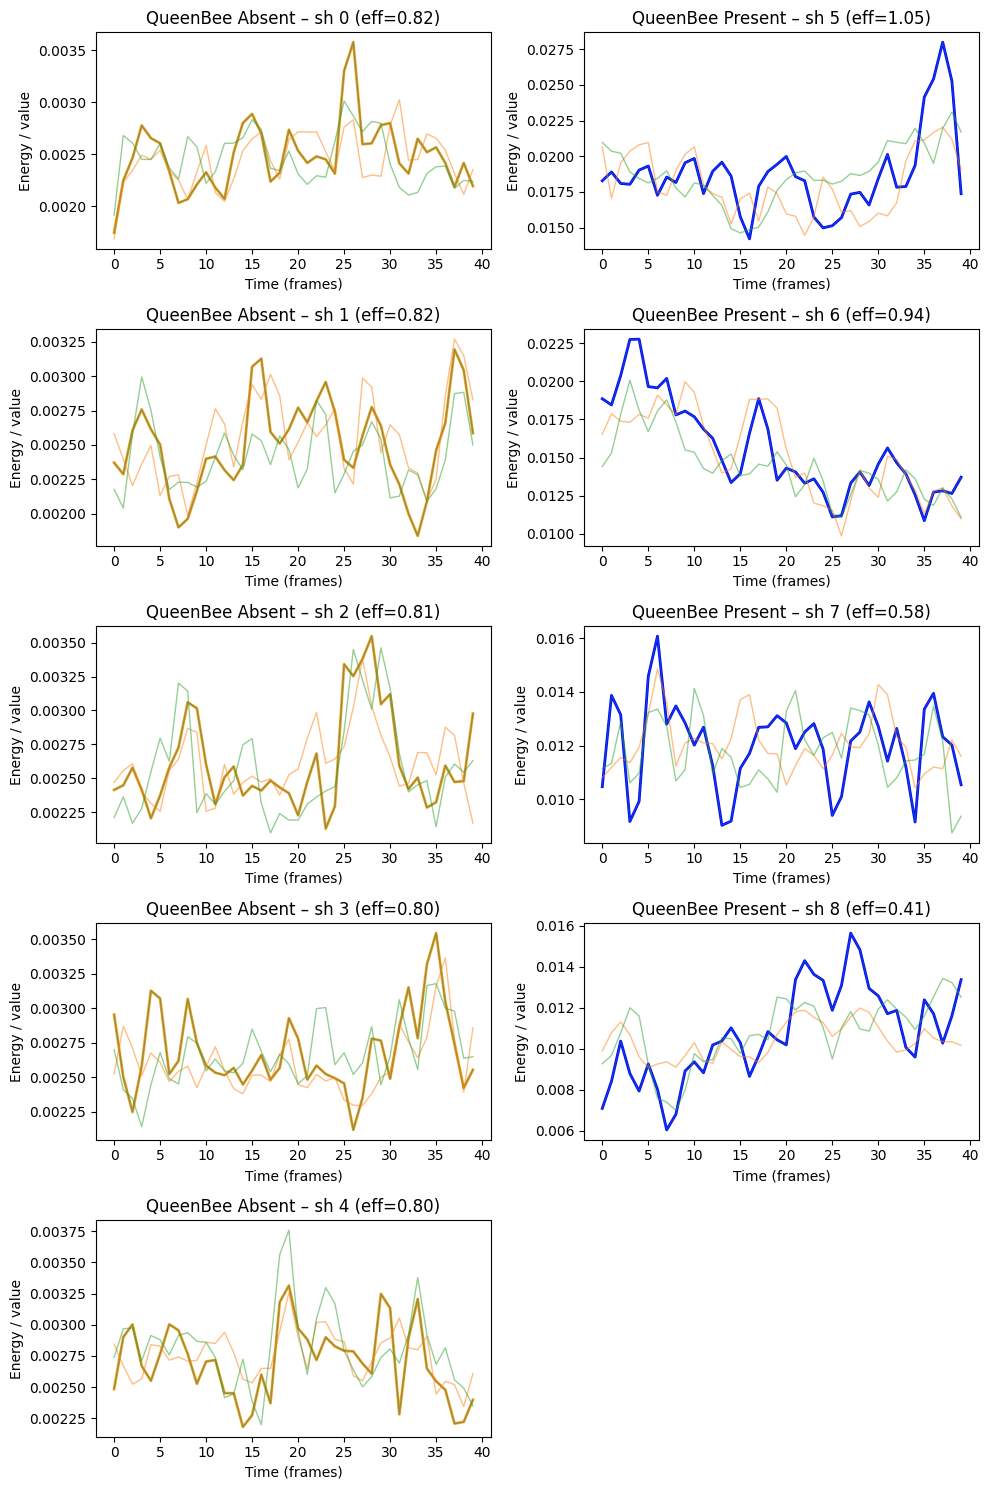

In [29]:
plot_shapelets_two_columns_correct(top_n=3, min_effect=0.3)
